In [214]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

sys.path.append('../../SketchRNN_tf2')
from sketchrnn import models, dataset, utils

sns.set('notebook', 'whitegrid', rc=utils.mpl_rc())

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))

tf: 2.5.0
tf.keras: 2.5.0


In [123]:
import IProgress
import ipywidgets
import random

In [10]:
!pwd

/home/etiennesdb/code/Tchook115/ouatai/notebooks


In [11]:
sys.path.append('../../SketchRNN_tf2')
from sketchrnn import models, dataset, utils

## dessine moi un objet

In [118]:
def dessine_moi_un(word):
    words = ['bulldozer', 'cat', 'rabbit']
    if word not in words:
        if word == 'tchook115':
            print('soyons sérieux')
            return 1
        print('essaie un autre mot stp')
        return 1
    
    #test de variables random
    max_seq_len = 147
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
    fichiers = {
        'bulldozer': 'sketch_rnn_bulldozer_weights.79_0.21.hdf5', 
        'cat' : 'sketch_rnn_cat_weights.78_0.01.hdf5',
        'rabbit' : 'sketch_rnn_rabbit_weights.100_0.06.hdf5'
               }
    checkpoint = os.path.join('../../SketchRNN_tf2/models/', fichiers[word])
    sketchrnn.load_weights(checkpoint)
    
    #building image
    fig, ax = plt.subplots(figsize=(3, 3))

    strokes = sketchrnn.sample(temperature=0.3)
    utils.plot_strokes(ax, utils.to_normal_strokes(strokes))

    utils.plt_show()

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_bulldozer_weights.79_0.21.hdf5


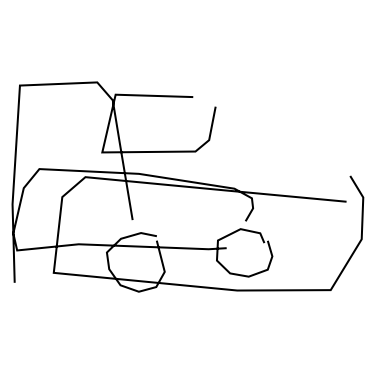

In [119]:
dessine_moi_un('bulldozer')

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_cat_weights.78_0.01.hdf5


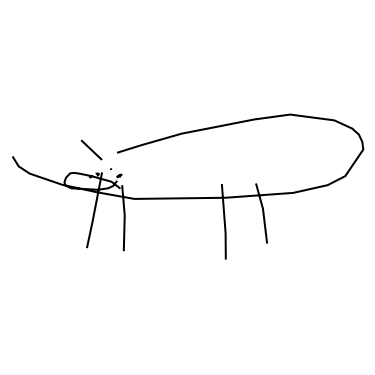

In [120]:
dessine_moi_un('cat')

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_rabbit_weights.100_0.06.hdf5


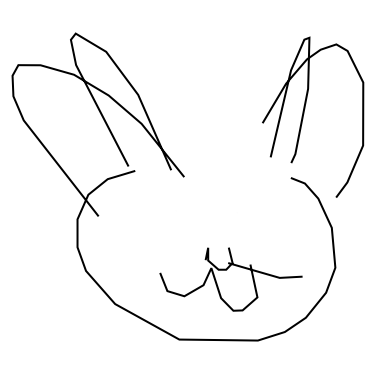

In [6]:
dessine_moi_un('rabbit')

In [55]:
dessine_moi_un('ornithorynque')

essaie un autre mot stp


1

In [162]:
best_images = {
    'bulldozer': np.load('../raw_data/Best_images/best_bulldozer.npy', allow_pickle=True),
    'rabbit' : np.load('../raw_data/Best_images/best_rabbit.npy', allow_pickle=True), 
    'cat' : np.load('../raw_data/Best_images/best_cat.npy', allow_pickle=True)
}

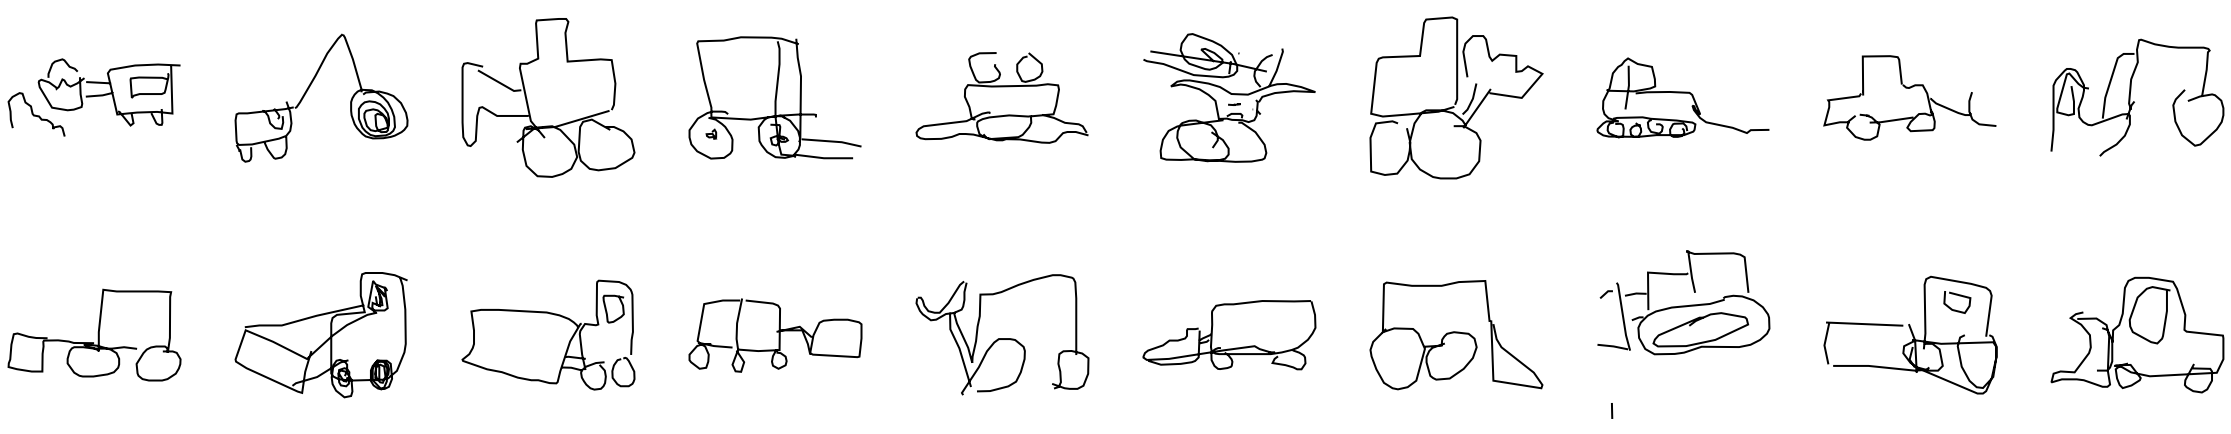

In [168]:
word = 'bulldozer'
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for index, ax in enumerate(axs[0]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index]))
for index, ax in enumerate(axs[1]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index+10]))

In [220]:
def dessine_moi_avec_best_image(word, temperature = 0.2):
    words = ['bulldozer', 'cat', 'rabbit']
    if word not in words:
        return 'essaie un autre mot stp'
    
    #test de variables random
    max_seq_len = best_images[word][0].shape[0]-1
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    
    # load model
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
    fichiers = {
        'bulldozer': 'sketch_rnn_bulldozer_weights.79_0.21.hdf5', 
        'cat' : 'sketch_rnn_cat_weights.78_0.01.hdf5',
        'rabbit' : 'sketch_rnn_rabbit_weights.100_0.06.hdf5'
               }
    checkpoint = os.path.join('../../SketchRNN_tf2/models/', fichiers[word])
    sketchrnn.load_weights(checkpoint)
    
    
    # building image 
    best_pic = random.choice(best_images[word])
#     best_pic = best_images[word][2]
    d = np.expand_dims(best_pic,0)
    z = sketchrnn.models['encoder'].predict(d[:,1:])[0]
    strokes = sketchrnn.sample(z=z, temperature=temperature)
    
    final_object = utils.to_normal_strokes(strokes)
    fig, ax = plt.subplots(figsize=(3, 3))
    utils.plot_strokes(ax, final_object)
    utils.plt_save(filename = '../raw_data/Best_images/best_'+word+'.svg')
    
    return strokes, final_object

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_rabbit_weights.100_0.06.hdf5


AttributeError: module 'sketchrnn.utils' has no attribute 'plt_save'

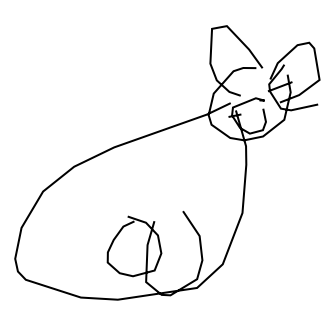

In [221]:
dessine_moi_avec_best_image('rabbit')

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_bulldozer_weights.79_0.21.hdf5


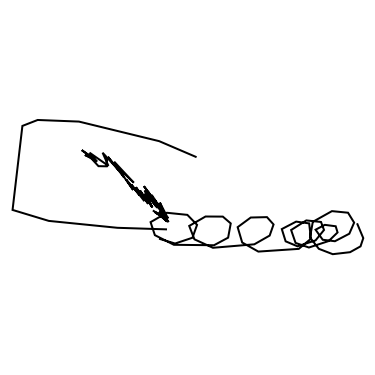

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_bulldozer_weights.79_0.21.hdf5


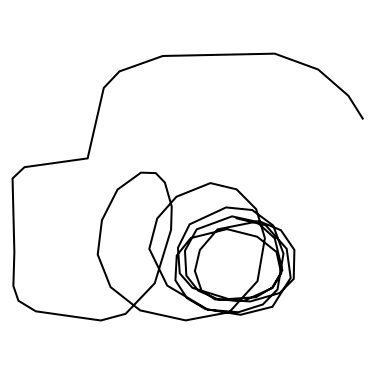

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_bulldozer_weights.79_0.21.hdf5


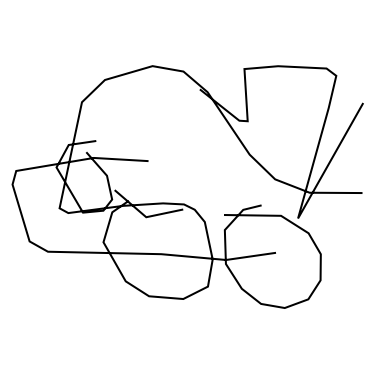

In [166]:
for k in range(3):
    dessine_moi_avec_best_image('bulldozer')

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_cat_weights.78_0.01.hdf5


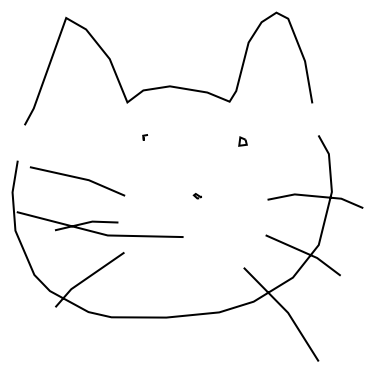

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_cat_weights.78_0.01.hdf5


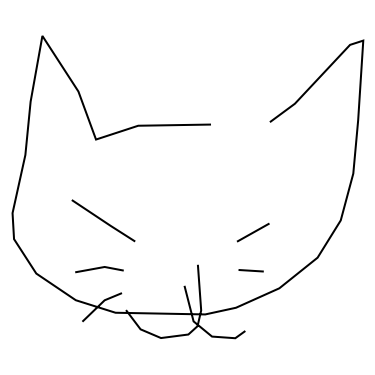

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_cat_weights.78_0.01.hdf5


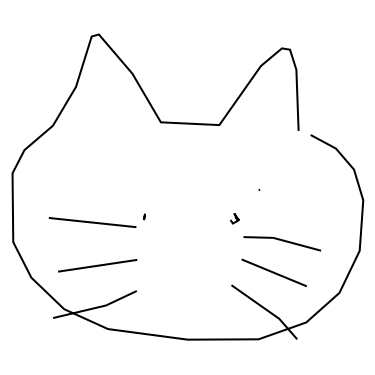

In [167]:
for k in range(3):
    dessine_moi_avec_best_image('cat')

## renvoie moi un svg

Loaded Weights From: ../../SketchRNN_tf2/models/sketch_rnn_cat_weights.78_0.01.hdf5


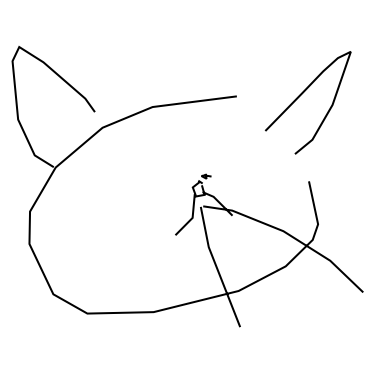

In [184]:
stroke, final_object = dessine_moi_avec_best_image('cat')

In [185]:
stroke

array([[-9.3228245e-01,  1.2498672e+00,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [-1.2879474e-01,  6.0675824e-01,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 7.5749353e-02,  2.2028877e-01,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 3.8088733e-01,  3.7299132e-01,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 6.6474032e-01,  3.4778163e-01,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 1.2001193e+00,  2.9858574e-01,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 9.3616128e-01,  2.0392226e-02,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 4.7997230e-01, -2.7170578e-01,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [ 3.3771604e-01, -7.1038610e-01,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [-8.1056068e-03, -4.5755157e-01,  1.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [-3.6226580e-01, -6.220